In [1]:
%matplotlib inline

In [13]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## 2017-11-21, 2017-11-25

First experiments, followed by more experiments and code cleanup

In [183]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression


def plot_data_in_R3(first_class, second_class, first_test, second_test, ax):
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111, projection='3d')

    ax.scatter(first_class[:, 0], first_class[:, 1], first_class[:, 2], label='$c=1$')
    ax.scatter(second_class[:, 0], second_class[:, 1], second_class[:, 2], label='$c=2$')

    ax.scatter(first_test[:, 0], first_test[:, 1], first_test[:, 2], label='$c=1$ test set')
    ax.scatter(second_test[:, 0], second_test[:, 1], second_test[:, 2], label='$c=2$ test set')

    ax.legend(loc=2, fontsize=12)
    ax.set_xlabel('X', size=12)
    ax.set_ylabel('Y', size=12)
    ax.set_zlabel('Z', size=12)
#     plt.show()
    
    
def plot_lda_projection(transformed_data, title, ax):
    n = int(transformed_data.shape[0] / 2)
    
#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111) 
    
    ax.scatter(transformed_X[:n], [1] * n, label='$c=1$', alpha=0.33)
    ax.scatter(transformed_X[n:], [2] * n, label='$c=2$', alpha=0.33)
    
    ax.set_ylim(0, 3)
    ax.legend(loc='best', fontsize=16)
    ax.set_xlabel('X', size=12)
    ax.set_ylabel('Y', size=12)
    ax.set_title(title)
#     plt.show()
    

def nullspace_using_svd(A, eps=1e-15):
    u, s, v = np.linalg.svd(A)
    null_space = v[s.shape[0]:]
    return null_space.T
    
    
def plot_logistic_regression(reg, transformed_X, transformed_ns_X, ax):
    def line(x0):
        return (-(x0 * reg.coef_[0, 0]) - reg.intercept_[0]) / reg.coef_[0, 1]

#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111) 
    ax.scatter(transformed_X[:N], transformed_ns_X[:N], label='$c=1$')
    ax.scatter(transformed_X[N:], transformed_ns_X[N:], label='$c=2$')
    
    xmin, xmax = ax.get_xlim()
    orig_ylim = ax.get_ylim()
    ax.plot([xmin, xmax], [line(xmin), line(xmax)], ls='--', color='black', label='Decision boundry')
    ax.set_ylim(ylim)

    ax.legend(loc=2)
    ax.set_xlabel('First LDA projection', size=12)
    ax.set_ylabel('Second LDA projection', size=12)
    ax.set_title('Logistic regression decision boundary')
#     plt.show()
    
    
def lda_projection_experiment(first_class, second_class, first_test, second_test):
    n, d = first_class.shape
    
    plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, hspace=0.3)

    if 3 == d:
        plot_data_in_R3(first_class, second_class, first_test, second_test, 
                        plt.subplot(gs[0, 0], projection='3d'))
    
    # Train and test set cleanup
    X = np.vstack([first_class, second_class])
    y = np.asarray([1] * N + [2] * N)
    X_test = np.vstack([first_test, second_test])
    y_test = np.asarray([1] * TEST_N + [2] * TEST_N)
    
    # First LDA projection
    first_lda = LinearDiscriminantAnalysis(n_components=1)
    transformed_X = first_lda.fit_transform(X, y)
    plot_lda_projection(transformed_X, 'First LDA Projection', plt.subplot(gs[0, 1]))
    
    print('First LDA projection:')
    first_train_acc = np.sum(first_lda.predict(X) == y) / y.shape[0]
    first_test_acc = np.sum(first_lda.predict(X_test) == y_test) / y_test.shape[0]
    print('Train prediction accuracy:', first_train_acc)
    print('Test prediction accuracy:', first_test_acc)
    
    # Project onto nullspace
    ns = nullspace_using_svd(first_lda.coef_)
    X_ns = X.dot(ns)
    X_ns_test = X_test.dot(ns)
    
    # Second LDA projection
    second_lda = LinearDiscriminantAnalysis(n_components=1)
    transformed_ns_X = second_lda.fit_transform(X_ns, y)
    plot_lda_projection(transformed_ns_X, 'Second LDA Projection', plt.subplot(gs[1, 0]))
    
    print('Second LDA projection:')
    second_train_acc = np.sum(second_lda.predict(X_ns) == y) / y.shape[0]
    second_test_acc = np.sum(second_lda.predict(X_ns_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', second_train_acc)
    print('Test Prediction accuracy:', second_test_acc)
    
    # Logistic Regression model
    both_transformed_X = np.hstack([transformed_X, transformed_ns_X])
    both_transformed_X_test = np.hstack([first_lda.transform(X_test), 
                                         second_lda.transform(X_ns_test)])

    reg = LogisticRegression()
    reg.fit(both_transformed_X, y)
    plot_logistic_regression(reg, transformed_X, transformed_ns_X, plt.subplot(gs[1, 1]))
    
    print('Combined logistic regression:')
    logit_train_acc = np.sum(reg.predict(both_transformed_X) == y) / y.shape[0]
    logit_test_acc = np.sum(reg.predict(both_transformed_X_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', logit_train_acc)
    print('Test Prediction accuracy:', logit_test_acc)
    
    plt.show()
    
    headers = ('Dataset', 'First LDA', 'Second LDA', 'Combined Logistic')
    
    rows = [
        ('Train', first_train_acc, second_train_acc, logit_train_acc),
        ('Test', first_test_acc, second_test_acc, logit_test_acc)
    ]
    
    print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))
    
    


## Data in $\mathbb{R}^3$, diagonal covariance

First LDA projection:
Train prediction accuracy: 0.7285
Test prediction accuracy: 0.745
Second LDA projection:
Train rediction accuracy: 0.544
Test Prediction accuracy: 0.565
Combined logistic regression:
Train rediction accuracy: 0.727
Test Prediction accuracy: 0.745


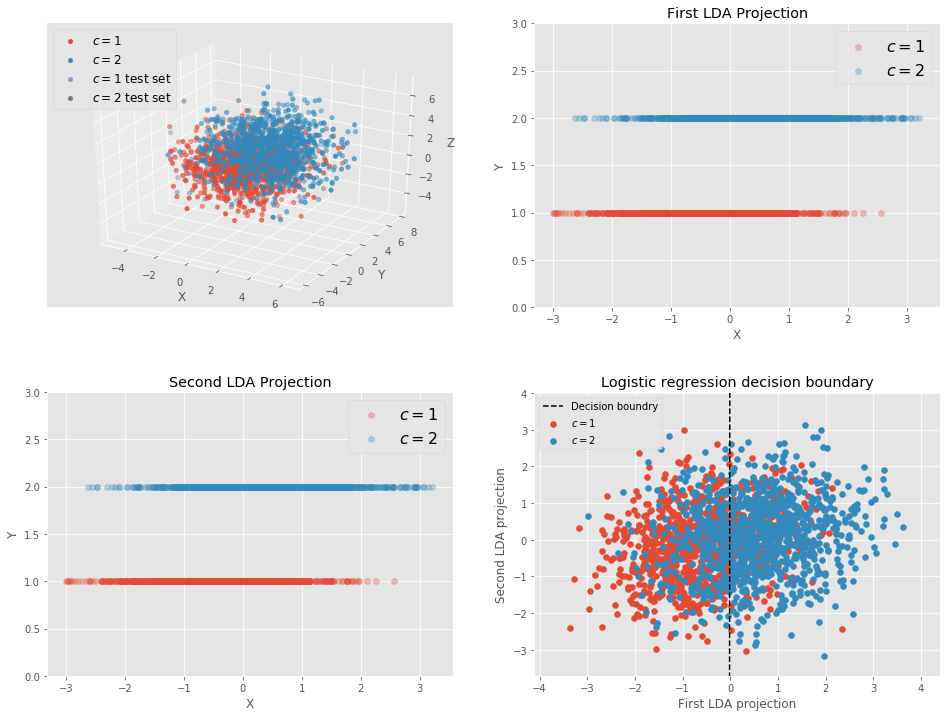

╒═══════════╤═════════════╤══════════════╤═════════════════════╕
│ Dataset   │   First LDA │   Second LDA │   Combined Logistic │
╞═══════════╪═════════════╪══════════════╪═════════════════════╡
│ Train     │      0.7285 │        0.544 │               0.727 │
├───────────┼─────────────┼──────────────┼─────────────────────┤
│ Test      │      0.745  │        0.565 │               0.745 │
╘═══════════╧═════════════╧══════════════╧═════════════════════╛


In [184]:
np.random.seed(RANDOM_SEED)

D = 3

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test)

## Data in $\mathbb{R}^3$, full covariance

First LDA projection:
Train prediction accuracy: 0.64
Test prediction accuracy: 0.7
Second LDA projection:
Train rediction accuracy: 0.561
Test Prediction accuracy: 0.56
Combined logistic regression:
Train rediction accuracy: 0.64
Test Prediction accuracy: 0.695


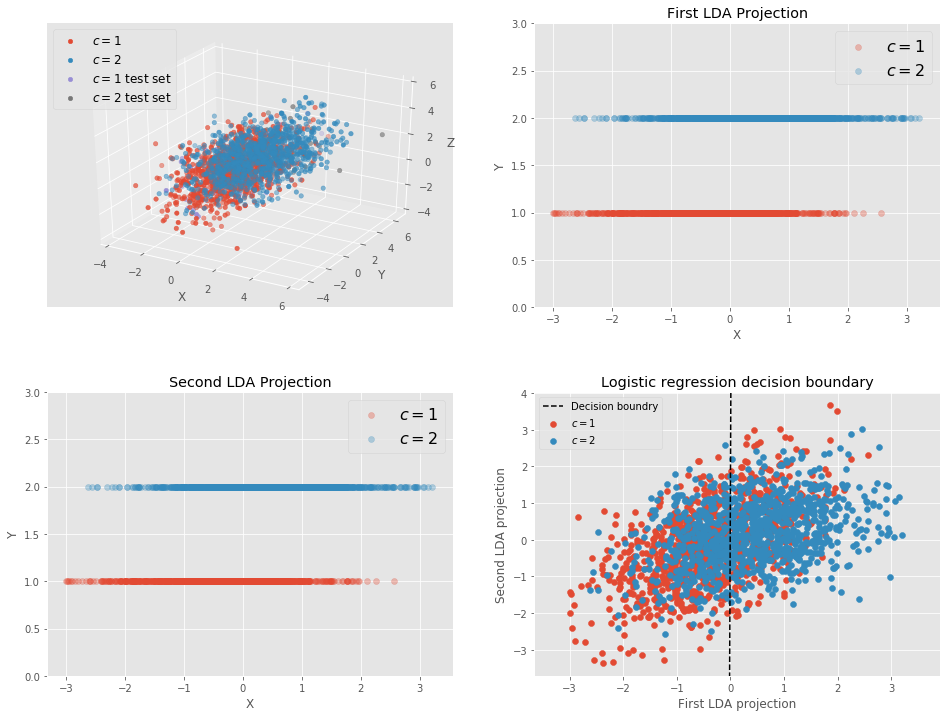

╒═══════════╤═════════════╤══════════════╤═════════════════════╕
│ Dataset   │   First LDA │   Second LDA │   Combined Logistic │
╞═══════════╪═════════════╪══════════════╪═════════════════════╡
│ Train     │        0.64 │        0.561 │               0.64  │
├───────────┼─────────────┼──────────────┼─────────────────────┤
│ Test      │        0.7  │        0.56  │               0.695 │
╘═══════════╧═════════════╧══════════════╧═════════════════════╛


In [185]:
np.random.seed(RANDOM_SEED)

D = 3

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test)

## Data in $\mathbb{R}^{10}$, full covariance

First LDA projection:
Train prediction accuracy: 0.835
Test prediction accuracy: 0.83
Second LDA projection:
Train rediction accuracy: 0.556
Test Prediction accuracy: 0.555
Combined logistic regression:
Train rediction accuracy: 0.835
Test Prediction accuracy: 0.83


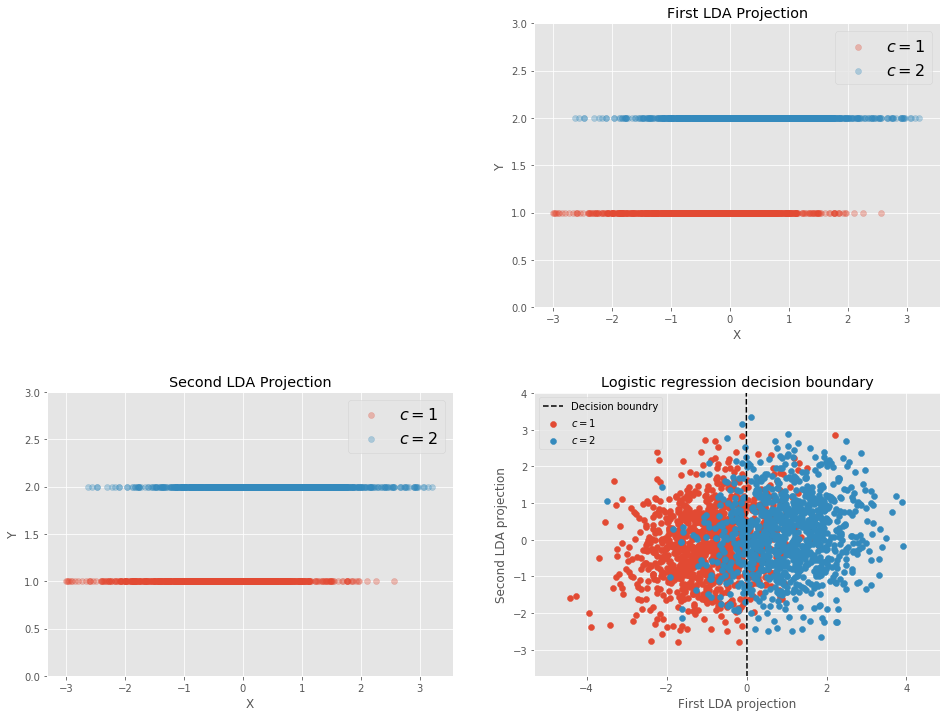

╒═══════════╤═════════════╤══════════════╤═════════════════════╕
│ Dataset   │   First LDA │   Second LDA │   Combined Logistic │
╞═══════════╪═════════════╪══════════════╪═════════════════════╡
│ Train     │       0.835 │        0.556 │               0.835 │
├───────────┼─────────────┼──────────────┼─────────────────────┤
│ Test      │       0.83  │        0.555 │               0.83  │
╘═══════════╧═════════════╧══════════════╧═════════════════════╛


In [186]:
np.random.seed(RANDOM_SEED)

D = 10

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test)

## Data in $\mathbb{R}^{10}$, full covariance

First LDA projection:
Train prediction accuracy: 0.688
Test prediction accuracy: 0.66
Second LDA projection:
Train rediction accuracy: 0.6295
Test Prediction accuracy: 0.54
Combined logistic regression:
Train rediction accuracy: 0.6855
Test Prediction accuracy: 0.66


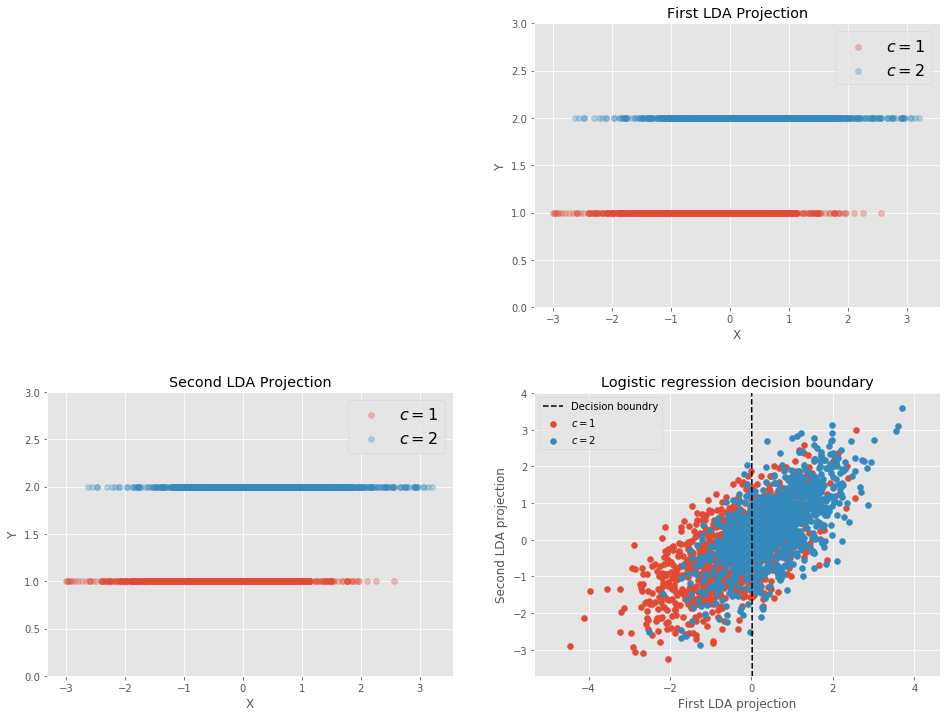

╒═══════════╤═════════════╤══════════════╤═════════════════════╕
│ Dataset   │   First LDA │   Second LDA │   Combined Logistic │
╞═══════════╪═════════════╪══════════════╪═════════════════════╡
│ Train     │       0.688 │       0.6295 │              0.6855 │
├───────────┼─────────────┼──────────────┼─────────────────────┤
│ Test      │       0.66  │       0.54   │              0.66   │
╘═══════════╧═════════════╧══════════════╧═════════════════════╛


In [187]:
np.random.seed(RANDOM_SEED)

D = 10

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test)